In [1]:
import pandas as pd

# Load, make date column datetime datatype, and filter the dataset to one product
df = pd.read_csv("../data/sales_data.csv")
df['date'] = pd.to_datetime(df['date'])
df = df[df['product_line'] == 'Alpha'].sort_values('date')

# Preview the structure
df.head()

,date,product_line,monthly_bookings
0,2021-01-01,Alpha,110051
1,2021-02-01,Alpha,109266
2,2021-03-01,Alpha,116108
3,2021-04-01,Alpha,120895
4,2021-05-01,Alpha,104935


In [2]:
#split 80/20 for training and test data
split_idx = int(len(df) * 0.8)
df_train = df.iloc[:split_idx]
df_test = df.iloc[split_idx:]
#below was debugging as plot was replicating actuals x4 values on merge.
df_train['date'].value_counts().sort_index()

date
2021-01-01    1
2021-02-01    1
2021-03-01    1
2021-04-01    1
2021-05-01    1
2021-06-01    1
2021-07-01    1
2021-08-01    1
2021-09-01    1
2021-10-01    1
2021-11-01    1
2021-12-01    1
2022-01-01    1
2022-02-01    1
2022-03-01    1
2022-04-01    1
2022-05-01    1
2022-06-01    1
2022-07-01    1
2022-08-01    1
2022-09-01    1
2022-10-01    1
2022-11-01    1
2022-12-01    1
2023-01-01    1
2023-02-01    1
2023-03-01    1
2023-04-01    1
Name: count, dtype: int64

In [3]:
# Format for Prophet
df_prophet_train = df_train.rename(columns={'date': 'ds', 'monthly_bookings': 'y'})[['ds', 'y']]
df_prophet_test = df_test.rename(columns={'date': 'ds', 'monthly_bookings': 'y'})[['ds', 'y']]
#below was debugging as plot was replicating actuals x4 values
df_prophet_train['ds'].value_counts().sort_index()

ds
2021-01-01    1
2021-02-01    1
2021-03-01    1
2021-04-01    1
2021-05-01    1
2021-06-01    1
2021-07-01    1
2021-08-01    1
2021-09-01    1
2021-10-01    1
2021-11-01    1
2021-12-01    1
2022-01-01    1
2022-02-01    1
2022-03-01    1
2022-04-01    1
2022-05-01    1
2022-06-01    1
2022-07-01    1
2022-08-01    1
2022-09-01    1
2022-10-01    1
2022-11-01    1
2022-12-01    1
2023-01-01    1
2023-02-01    1
2023-03-01    1
2023-04-01    1
Name: count, dtype: int64

In [18]:
from prophet import Prophet

model_prophet = Prophet()
model_prophet.fit(df_prophet_train)

08:35:08 - cmdstanpy - INFO - Chain [1] start processing
08:35:08 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
# Create Prophet forecast
future = df_prophet_test[['ds']].copy()
forecast = model_prophet.predict(future)

# Match forecast length to df_prophet_test to avoid plot errors
forecast = forecast.iloc[:len(df_prophet_test)].copy()


In [24]:
df_eval_prophet = forecast[['ds', 'yhat']].merge(df_prophet_test[['ds', 'y']], on='ds', how='inner')

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_prophet = mean_absolute_error(df_eval_prophet['y'], df_eval_prophet['yhat'])
rmse_prophet = np.sqrt(mean_squared_error(df_eval_prophet['y'], df_eval_prophet['yhat']))

print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Prophet RMSE: {rmse_prophet:.2f}")

Prophet MAE: 15806.44
Prophet RMSE: 19587.35


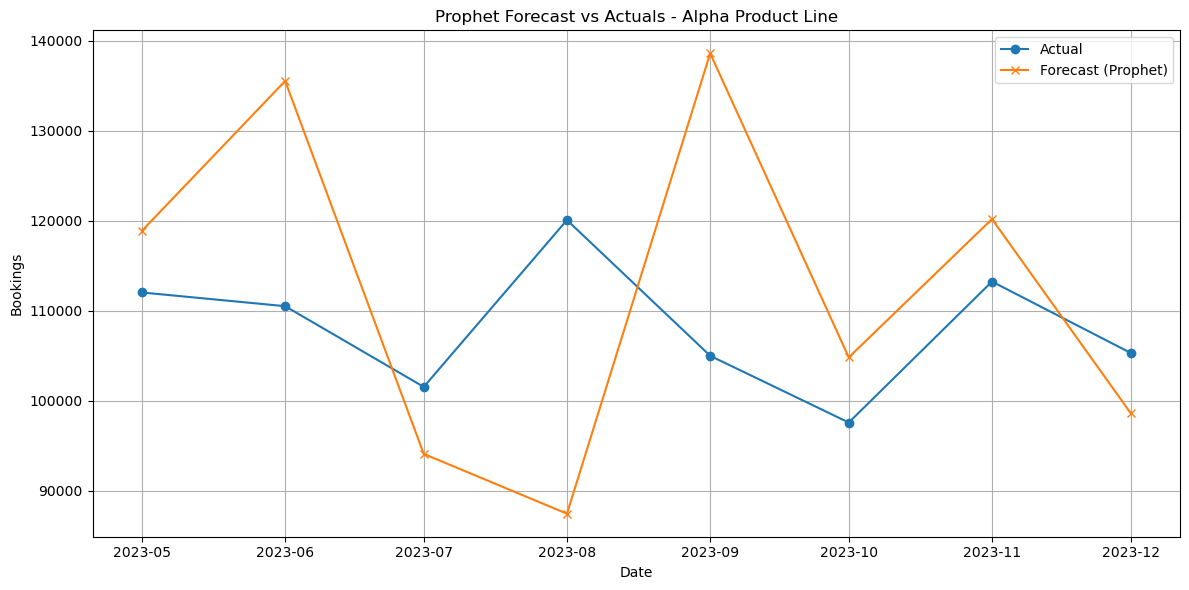

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_eval_prophet['ds'], df_eval_prophet['y'], label='Actual', marker='o')
plt.plot(df_eval_prophet['ds'], df_eval_prophet['yhat'], label='Forecast (Prophet)', marker='x')
plt.title('Prophet Forecast vs Actuals - Alpha Product Line')
plt.xlabel('Date')
plt.ylabel('Bookings')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [71]:
# Transitioning from Prophet to XGBoost to see if we can improve forecasting accuracy
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [73]:
#Let's XGBoost see previous months's values as predictors
df_xgb_train = df_train.copy()
df_xgb_train = df_xgb_train.set_index('date')

# Create lag features
for lag in [1, 2, 3]:
    df_xgb_train[f'lag_{lag}'] = df_xgb_train['monthly_bookings'].shift(lag)

# Drop rows with NaNs from shifting, this will drop first 3 months as lag has 3 month lookback
df_xgb_train = df_xgb_train.dropna()



In [75]:
X_train = df_xgb_train[['lag_1', 'lag_2', 'lag_3']]
y_train = df_xgb_train['monthly_bookings']

In [77]:
df_xgb_test = df_test.copy()
df_xgb_test = df_xgb_test.set_index('date')

for lag in [1, 2, 3]:
    df_xgb_test[f'lag_{lag}'] = df_xgb_test['monthly_bookings'].shift(lag)

df_xgb_test = df_xgb_test.dropna()

X_test = df_xgb_test[['lag_1', 'lag_2', 'lag_3']]
y_test = df_xgb_test['monthly_bookings']

In [79]:
predictions = model_xgb.predict(X_test)

print(f"y_test shape: {y_test.shape}")
print(f"predictions shape: {predictions.shape}")

y_test shape: (5,)
predictions shape: (5,)


In [81]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(objective='reg:squarederror')
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)


In [83]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")




XGBoost MAE: 12622.69
XGBoost RMSE: 14062.70


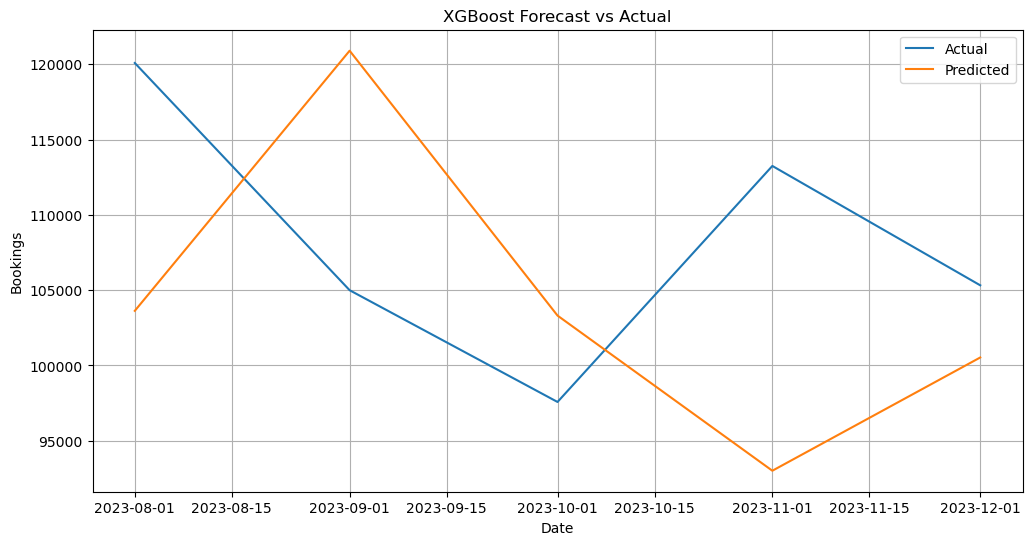

In [85]:
import matplotlib.pyplot as plt

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, predictions, label='Predicted')
plt.title('XGBoost Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Bookings')
plt.legend()
plt.grid(True)
plt.show()

## Model Comparison: Prophet vs XGBoost

We compared two forecasting models using a holdout test set from the Alpha product line.

### 📊 Performance Metrics

**Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)**:

- **Prophet**
  - MAE: $15,806.44
  - RMSE: $19,587.35

- **XGBoost**
  - MAE: $12,622.69
  - RMSE: $14,062.70

### Findings:
- **XGBoost outperformed Prophet** on both MAE and RMSE, indicating it was more accurate at capturing short-term patterns in the sales data.
- Prophet's performance may have been limited due to less seasonality and trend in the data.
- XGBoost's use of recent lagged values likely helped it adapt more quickly to changes in bookings behavior.

### Recommendation:
Use **XGBoost** as the preferred model for short-horizon forecasting in this case, particularly if recent history is a strong driver of future sales. Consider Prophet for longer-term strategic forecasting when clear seasonal or trend components are present.


